In [2]:
import sys
sys.path.append('D:\\Projects\\nlp-projects\\utils')
print(sys.path)

['C:\\Users\\legion\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\legion\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\legion\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\legion\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\Projects\\nlp-projects\\.venv', '', 'd:\\Projects\\nlp-projects\\.venv\\Lib\\site-packages', 'd:\\Projects\\nlp-projects\\.venv\\Lib\\site-packages\\win32', 'd:\\Projects\\nlp-projects\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\Projects\\nlp-projects\\.venv\\Lib\\site-packages\\Pythonwin', 'D:\\Projects\\nlp-projects\\utils', 'D:\\Projects\\nlp-projects\\utils']


In [3]:
from bs4 import BeautifulSoup
import requests
from math import log10
import json
import re
import nltk
from nltk.corpus import stopwords
import clean
import utils
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import qalsadi.lemmatizer
from farasa.pos import FarasaPOSTagger 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch import nn
import numpy as np

In [4]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [5]:
BASE_URL = 'https://www.aljazeera.net'

articles = []
articlesTitles = []
articlesLinks = []
articlesDates = []
articlesContents = []
articlesTopics = ['/news',
                '/where/arab/palestine/',
                '/where/arab/sudan/',
                '/where/europe/ukraine/',
                '/politics/']

In [ ]:
driver = webdriver.Chrome()

for topic in articlesTopics:
    driver.get(BASE_URL + topic)
    driver.implicitly_wait(10)

    XPath = '/html/body/div[1]/div/div[3]/div/div[3]/div/div[1]/section/button'
    element = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, XPath)))
    driver.execute_script("arguments[0].scrollIntoView();", element)
    element.click()

    for i in range(50):
        element = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, XPath)))
        driver.execute_script("arguments[0].scrollIntoView();", element)
        element.click()
    
    # get the articles
    temp_articlesLinks = driver.find_elements('xpath', '//a[@class="u-clickable-card__link"]')

    for articleLink in temp_articlesLinks:
        articlesLinks.append(articleLink.get_attribute('href'))

driver.close()

In [ ]:
len(articlesLinks)

2070

In [ ]:
articlesLinks[0]

'https://www.aljazeera.net/news/2024/5/21/%d9%85%d8%ad%d9%83%d9%85%d8%a9-%d9%8a%d9%88%d9%86%d8%a7%d9%86%d9%8a%d8%a9-%d8%aa%d8%a8%d8%b1%d9%89%d8%a1-%d8%aa%d8%b3%d8%b9%d8%a9-%d9%85%d8%aa%d9%87%d9%85%d9%8a%d9%86'

In [ ]:
with open('tmp/links.json', 'w', encoding='utf-8') as json_file:
    json.dump(articlesLinks, json_file, indent=4, ensure_ascii=False)

In [ ]:
# remove links that dont start with 'https://www.aljazeera.net', revome respectiv title
for link in articlesLinks:
    if not link.startswith('https://www.aljazeera.net'):
        index = articlesLinks.index(link)
        articlesLinks.pop(index)

In [ ]:
len(articlesLinks)

2039

In [ ]:
with open('tmp/links.json', 'r', encoding='utf-8') as json_file:
    articlesLinks = json.load(json_file)

In [ ]:
printProgressBar(0, 500, prefix = 'Progress:', suffix = 'Complete', length = 100)

for i in range(500):
    url = articlesLinks[i]
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    article = ''

    articleDate = soup.select('div[class*="article-dates"]')[0].text

    articleTitle = soup.find('h1').text

    articlesParagraphsContainer = soup.select('div[class*="wysiwyg wysiwyg--all-content"]')[0]

    articlesParagraphs = articlesParagraphsContainer.find_all('p', recursive=False)

    articlesDates.append(articleDate)

    articlesTitles.append(articleTitle)

    for p in articlesParagraphs:
        article += p.text + '\n'

    articlesContents.append(article)

    time.sleep(0.1)
    # Update Progress Bar
    printProgressBar(i + 1, 500, prefix = 'Progress:', suffix = 'Complete', length = 100)

print('Articles dates retrieved!')
print('Articles Contents retrieved!')
for i in range(len(articlesTitles)):
    articles.append({
        'title': articlesTitles[i],
        'link': articlesLinks[i],
        'date': articlesDates[i],
        'content': articlesContents[i]
    })

Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Articles dates retrieved!
Articles Contents retrieved!


In [ ]:
# If you are on Google Colab:
# with open('/content/tmp/aljazzera.json', 'w', encoding='utf-8') as json_file:
with open('tmp/aljazzera.json', 'w', encoding='utf-8') as json_file:
    json.dump(articles, json_file, indent=4, ensure_ascii=False)

In [ ]:
# clean memory
del articles
del articlesTitles
del articlesLinks
del articlesDates
del articlesContents
del articlesTopics

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
mute_articles = articles

In [ ]:
for article in mute_articles:
    article['content'] = clean.remove_punctuations(article['content'])
    article['content'] = clean.remove_diacritics(article['content'])
    article['content'] = clean.normalize_arabic(article['content'])

    stop_words_patterns = r'\b('+ '|'.join(stopword for stopword in stopwords.words('arabic'))+ r')\b'

    article['content'] = re.sub(stop_words_patterns, '', article['content'])
    article['content'] = re.sub(' +', ' ', article['content'])

    # sentence count, split by \n
    article['sentence_count'] = len(article['content'].split('\n'))

    # topic count: the number of occurences of the topic word in the article
    article['topic_count'] = len(re.findall('فلسطين', article['content'])) + len(re.findall('غزه', article['content'])) + len(re.findall('القدس', article['content'])) + len(re.findall('غزة', article['content'])) + len(re.findall('فلسطين', article['title'])) + len(re.findall('غزه', article['title'])) + len(re.findall('القدس', article['title'])) + len(re.findall('غزة', article['title'])) + len(re.findall('رفح ', article['title']))

In [ ]:
mute_articles

[{'title': 'تأكيدا لتحقيق الجزيرة.. محكمة يونانية تبرئ 9 مصريين من مسؤولية غرق سفينة لاجئين',
  'link': 'https://www.aljazeera.net/news/2024/5/21/%d9%85%d8%ad%d9%83%d9%85%d8%a9-%d9%8a%d9%88%d9%86%d8%a7%d9%86%d9%8a%d8%a9-%d8%aa%d8%a8%d8%b1%d9%89%d8%a1-%d8%aa%d8%b3%d8%b9%d8%a9-%d9%85%d8%aa%d9%87%d9%85%d9%8a%d9%86',
  'date': '21/5/2024',
  'content': 'برات محكمه يونانيه اليوم الثلاثاء 9 مصريين متهمين بالتسبب اخطر حوادث غرق المهاجرين البحر الابيض المتوسط وذلك اليوم الاول محاكمتهم\nوقال قاضي محكمه كالاماتا جنوب ان المحكمه تعلن تبرءه المتهمين التسعه واسقاط التهم الموجهه اليهم\nوبعد مرور حوالي سنه علي غرق سفينه الصيد اكثر 80 قتيلا وحوالي 600 مفقود واجه المتهمون التسعه تهمه تسهيل الدخول القانوني للمهاجرين الي المنطقه والتسبب بالقتل نتيجه الاهمال واجهوا عقوبه السجن مدي الحياه بتهمه الانتماء الي منظمه اجراميه وهم رهن الحبس الاحتياطي 11 شهرا تقريبا\nوكشف تحقيق للجزيره منتصف فبرايرشباط الماضي ان المتهمين التسعه يكونوا المهربين نظموا الرحله او استفادوا واوضح الاشخاص التسعه حديثهم لمراسلي الجزيره ا

In [ ]:
# lemmatize
lemmatizer = qalsadi.lemmatizer.Lemmatizer()

for article in mute_articles:
    article['content'] = re.sub('\n', ' ', article['content'])
    article['content'] = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(article['content'])])

In [ ]:
# noun count
pos_tagger = FarasaPOSTagger()

printProgressBar(0, 500, prefix = 'Progress:', suffix = 'Complete', length = 100)
for article in mute_articles:
    article['noun_count'] = len(re.findall('NOUN', pos_tagger.tag(article['content'])))
    printProgressBar(mute_articles.index(article) + 1, 500, prefix = 'Progress:', suffix = 'Complete', length = 100)

Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


In [ ]:
mute_articles

[{'title': 'تأكيدا لتحقيق الجزيرة.. محكمة يونانية تبرئ 9 مصريين من مسؤولية غرق سفينة لاجئين',
  'link': 'https://www.aljazeera.net/news/2024/5/21/%d9%85%d8%ad%d9%83%d9%85%d8%a9-%d9%8a%d9%88%d9%86%d8%a7%d9%86%d9%8a%d8%a9-%d8%aa%d8%a8%d8%b1%d9%89%d8%a1-%d8%aa%d8%b3%d8%b9%d8%a9-%d9%85%d8%aa%d9%87%d9%85%d9%8a%d9%86',
  'date': '21/5/2024',
  'content': 'بر محكم يونان يوم ثلاثاء 9 مصري متهم تسبب خطر حوادث غرق مهاجر بحر ابيض متوسط ذلك يوم الاول محاكم قال قاضى محكم كالاماتا جنوب ان المحكمه علن تبرءه متهم التسعه واسقاط تهم الموجهه يهم بعد مرور حوال سن علي غرق سفين صيد كثر 80 قتيل حوال 600 مفقود جهي متهم التسعه تهم تسهيل دخول قانون مهاجر ال المنطقه تسبب قتل نتيجه الاهمال جهي عقوبه سجن مد لحى تهم انتماء ال منظم اجراميه هم رهن حبس احتياط 11 شهر تقريب شف تحقيق للجزيره منتصف فبرايرشباط ماضي ان متهم التسعه كون مهرب نظم الرحله او استفاد واوضح الاشخاص التسعه حديث مراسل الجزيره نهم كانو مجرد ركاب نجو غرق اتهم خفر سواحل يونان تسبب انقلاب قارب مكتظ خبر متهم أمات تبرءتهم مراسل الجزيره شركاء ان ادعاء يونان

In [ ]:
# compute scores
for article in mute_articles:
    score = article['sentence_count'] * article['noun_count'] * article['topic_count'] * (10**5)
    article['score'] = log10(score) if score != 0 else 0

In [ ]:
mute_articles

[{'title': 'تأكيدا لتحقيق الجزيرة.. محكمة يونانية تبرئ 9 مصريين من مسؤولية غرق سفينة لاجئين',
  'link': 'https://www.aljazeera.net/news/2024/5/21/%d9%85%d8%ad%d9%83%d9%85%d8%a9-%d9%8a%d9%88%d9%86%d8%a7%d9%86%d9%8a%d8%a9-%d8%aa%d8%a8%d8%b1%d9%89%d8%a1-%d8%aa%d8%b3%d8%b9%d8%a9-%d9%85%d8%aa%d9%87%d9%85%d9%8a%d9%86',
  'date': '21/5/2024',
  'content': 'بر محكم يونان يوم ثلاثاء 9 مصري متهم تسبب خطر حوادث غرق مهاجر بحر ابيض متوسط ذلك يوم الاول محاكم قال قاضى محكم كالاماتا جنوب ان المحكمه علن تبرءه متهم التسعه واسقاط تهم الموجهه يهم بعد مرور حوال سن علي غرق سفين صيد كثر 80 قتيل حوال 600 مفقود جهي متهم التسعه تهم تسهيل دخول قانون مهاجر ال المنطقه تسبب قتل نتيجه الاهمال جهي عقوبه سجن مد لحى تهم انتماء ال منظم اجراميه هم رهن حبس احتياط 11 شهر تقريب شف تحقيق للجزيره منتصف فبرايرشباط ماضي ان متهم التسعه كون مهرب نظم الرحله او استفاد واوضح الاشخاص التسعه حديث مراسل الجزيره نهم كانو مجرد ركاب نجو غرق اتهم خفر سواحل يونان تسبب انقلاب قارب مكتظ خبر متهم أمات تبرءتهم مراسل الجزيره شركاء ان ادعاء يونان

In [ ]:
# scale scores to be between 0 and 10
scores = [article['score'] for article in mute_articles]
max_score = max(scores)
min_score = min(scores)
print(max_score)
print(min_score)

for article in mute_articles:
    article['score'] = 10 * (article['score'] - min_score) / (max_score - min_score)

del scores
del max_score
del min_score

# remove unnecessary fields
for article in mute_articles:
    article.pop('sentence_count')
    article.pop('noun_count')
    article.pop('topic_count')
     
mute_articles

10.94090677610526
0


[{'title': 'تأكيدا لتحقيق الجزيرة.. محكمة يونانية تبرئ 9 مصريين من مسؤولية غرق سفينة لاجئين',
  'link': 'https://www.aljazeera.net/news/2024/5/21/%d9%85%d8%ad%d9%83%d9%85%d8%a9-%d9%8a%d9%88%d9%86%d8%a7%d9%86%d9%8a%d8%a9-%d8%aa%d8%a8%d8%b1%d9%89%d8%a1-%d8%aa%d8%b3%d8%b9%d8%a9-%d9%85%d8%aa%d9%87%d9%85%d9%8a%d9%86',
  'date': '21/5/2024',
  'content': 'بر محكم يونان يوم ثلاثاء 9 مصري متهم تسبب خطر حوادث غرق مهاجر بحر ابيض متوسط ذلك يوم الاول محاكم قال قاضى محكم كالاماتا جنوب ان المحكمه علن تبرءه متهم التسعه واسقاط تهم الموجهه يهم بعد مرور حوال سن علي غرق سفين صيد كثر 80 قتيل حوال 600 مفقود جهي متهم التسعه تهم تسهيل دخول قانون مهاجر ال المنطقه تسبب قتل نتيجه الاهمال جهي عقوبه سجن مد لحى تهم انتماء ال منظم اجراميه هم رهن حبس احتياط 11 شهر تقريب شف تحقيق للجزيره منتصف فبرايرشباط ماضي ان متهم التسعه كون مهرب نظم الرحله او استفاد واوضح الاشخاص التسعه حديث مراسل الجزيره نهم كانو مجرد ركاب نجو غرق اتهم خفر سواحل يونان تسبب انقلاب قارب مكتظ خبر متهم أمات تبرءتهم مراسل الجزيره شركاء ان ادعاء يونان

In [ ]:
with open('tmp/aljazzera_scored.json', 'w', encoding='utf-8') as json_file:
    json.dump(mute_articles, json_file, indent=4, ensure_ascii=False)

In [7]:
with open('tmp/aljazzera_scored.json', 'r', encoding='utf-8') as json_file:
    mute_articles = json.load(json_file)

In [8]:
# dataframe: only content, score
dataframe = pd.DataFrame(mute_articles)

dataframe.drop(['title', 'link', 'date'], axis=1, inplace=True)

dataframe

content     score
0    بر محكم يونان يوم ثلاثاء 9 مصري متهم تسبب خطر ...  8.387882
1    غاز مجازر انتهى صف مراسل الجزيره نسا شريف منشو...  8.047864
2    بحث عضو مجلس السياده انتقال سود فريق اول ركن ش...  0.000000
3    اعربت لصى املها ان تكون المحكمه الجناءيه الدول...  8.373226
4    بر محكم يونان يوم ثلاثاء 9 مصري متهم تسبب خطر ...  8.387882
..                                                 ...       ...
503  خط مسبوق تاريخ صراع فلسطيني الاسراءيلي علن مدع...  9.851638
504  قال خبير عسكر والاستراتيجي عقيد ركن حاتم ريم ف...  0.000000
505  بحث عضو مجلس السياده انتقال سود فريق اول ركن ش...  0.000000
506  داع منظم هيومن رايتس ووتش الحقوقيه تدخل دولي ع...  0.000000
507  توقع هيءه دفاع الرءيس سودان معزول عمر بشير 80 ...  0.000000

[508 rows x 2 columns]

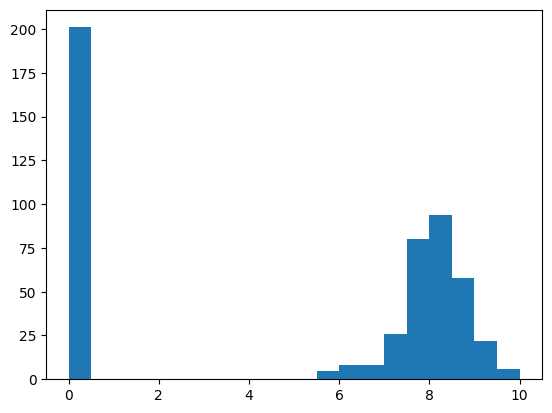

In [9]:
import matplotlib.pyplot as plt

plt.hist(dataframe['score'], bins=20)

plt.show()

In [10]:
tokenized_dataframe = dataframe.copy()

tokenized_dataframe['content'] = tokenized_dataframe['content'].apply(lambda x: utils.tokenize(x))

tokenized_dataframe

content     score
0    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
1    [غاز, مجازر, انتهى, صف, مراسل, الجزيره, نسا, ش...  8.047864
2    [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
3    [اعربت, لصى, املها, ان, تكون, المحكمه, الجناءي...  8.373226
4    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
..                                                 ...       ...
503  [خط, مسبوق, تاريخ, صراع, فلسطيني, الاسراءيلي, ...  9.851638
504  [قال, خبير, عسكر, والاستراتيجي, عقيد, ركن, حات...  0.000000
505  [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
506  [داع, منظم, هيومن, رايتس, ووتش, الحقوقيه, تدخل...  0.000000
507  [توقع, هيءه, دفاع, الرءيس, سودان, معزول, عمر, ...  0.000000

[508 rows x 2 columns]

In [11]:
# Number of unique words
unique_words = set(word for sentence in tokenized_dataframe['content'] for word in sentence)
print(len(unique_words))

# Number of non-empty sentences
non_empty_sentences = len([sentence for sentence in tokenized_dataframe['content'] if sentence])
print(non_empty_sentences)

11868
503


In [12]:
tokenized_dataframe = tokenized_dataframe[tokenized_dataframe['content'].apply(lambda x: len(x) > 0)]

tokenized_dataframe

content     score
0    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
1    [غاز, مجازر, انتهى, صف, مراسل, الجزيره, نسا, ش...  8.047864
2    [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
3    [اعربت, لصى, املها, ان, تكون, المحكمه, الجناءي...  8.373226
4    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
..                                                 ...       ...
503  [خط, مسبوق, تاريخ, صراع, فلسطيني, الاسراءيلي, ...  9.851638
504  [قال, خبير, عسكر, والاستراتيجي, عقيد, ركن, حات...  0.000000
505  [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
506  [داع, منظم, هيومن, رايتس, ووتش, الحقوقيه, تدخل...  0.000000
507  [توقع, هيءه, دفاع, الرءيس, سودان, معزول, عمر, ...  0.000000

[503 rows x 2 columns]

In [13]:
# Number of unique words
unique_words = set(word for sentence in tokenized_dataframe['content'] for word in sentence)
print(len(unique_words))

# Number of non-empty sentences
non_empty_sentences = len([sentence for sentence in tokenized_dataframe['content'] if sentence])
print(non_empty_sentences)

11868
503


In [14]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_dataframe['content'])

word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

11868

In [15]:
max(len(data) for data in tokenized_dataframe['content'])

1344

In [16]:
# padding text data
sequences = tokenizer.texts_to_sequences(tokenized_dataframe['content'])
padded_seq = pad_sequences(sequences, maxlen=131, padding='post', truncating='post')

In [17]:
embedding_index = {}

# https://archive.org/download/arabic_corpus
with open('../utils/models/vectors.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [18]:
len(embedding_index)

1538616

In [19]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 256))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
pd.DataFrame(embedding_matrix).drop(0, axis=0)

0         1         2         3         4         5         6    \
1      0.095790 -0.162807  0.374871  0.171119  0.143596 -0.786341 -0.100601   
2      0.140641  0.208688  0.346271 -0.211029 -0.662044 -0.206804 -0.374939   
3      0.217229 -0.518076 -0.355054 -0.030087  0.381885 -0.293346 -0.396668   
4     -0.964401  0.207093  0.221347 -0.200749  0.441631  0.577542  0.187373   
5      0.171996 -0.589999  0.487731  0.078550 -0.014830  0.795367  0.226420   
...         ...       ...       ...       ...       ...       ...       ...   
11864  0.015674  0.724328 -0.339269  0.150602  0.409828  0.108627  0.173773   
11865 -0.072771  0.175830 -0.614250  0.099588 -0.390133 -0.453218 -0.008400   
11866  0.133948  0.255858 -0.695649  0.253205 -0.132657 -0.592301  0.382268   
11867 -0.170485 -0.267147  0.299332  0.349626  0.426449  0.434045  0.717956   
11868  0.328942  0.029384  0.397043 -0.495581  0.135911  0.238516 -0.505830   

            7         8         9    ...       246       247       248  \
1      0.318639  0.015685 -0.261593  ...  0.533486 -0.024056  0.136263   
2      0.544606 -0.446713 -0.113337  ...  0.307947 -0.496236 -0.108284   
3      0.130833  0.155621 -0.758768  ...  0.849185  0.119259  0.119518   
4     -0.056670 -0.103848  0.417697  ... -0.255153  0.216525  0.285960   
5      0.486914  0.113267 -0.471484  ...  0.051409  0.042379 -0.018398   
...         ...       ...       ...  ...       ...       ...       ...   
11864  0.059204 -0.007548  0.076207  ... -0.219405 -0.473711  0.175901   
11865 -0.341267  0.920716 -0.424031  ... -0.136889 -0.080626 -0.415294   
11866 -0.246192 -0.103334 -0.620424  ...  0.016560  0.715659  0.268209   
11867  0.351752  0.068625 -0.117555  ... -0.369922  0.249124  0.354145   
11868  0.159540 -0.145362  0.250093  ...  0.441149 -0.126786 -0.245026   

            249       250       251       252       253       254       255  
1      0.317934 -0.095470  0.178957 -0.117983  0.101266 -0.169881  0.053150  
2     -0.747276 -0.257914 -0.387308 -0.751784 -0.357461  0.147876  0.095807  
3     -0.154845  0.461796 -0.837456  0.213790  0.125551  0.852417 -0.083400  
4     -0.407051 -0.243518 -0.654814  0.448573  0.270994  0.453717 -0.239554  
5      0.268279  0.284175 -0.035582 -0.452538 -0.073722  0.320527  0.337247  
...         ...       ...       ...       ...       ...       ...       ...  
11864 -0.169312  0.075151  0.055134  0.938739  0.221884 -0.182374  0.542045  
11865 -0.164764  0.350397  0.106757 -0.276366  0.041243 -0.179401 -0.518704  
11866 -0.063833  0.478849  0.383879 -0.282231  0.534879 -0.346035 -0.044020  
11867 -0.166596 -0.162143  0.087888 -0.124002 -0.200379 -0.140261  0.158617  
11868 -0.707867 -0.213425  0.068507 -0.221387 -0.060249  0.048565  0.166615  

[11868 rows x 256 columns]

In [21]:
def vectorize_text(text, embedding_matrix):
    words = text
    word_embeddings = [embedding_matrix[word_index[word]] for word in words if word in word_index]
    if not word_embeddings:  # if text doesn't contain any words in the Word2Vec model's vocabulary
        return np.zeros(256)
    return pd.Series(np.mean(word_embeddings, axis=0))

In [22]:
pd.DataFrame(tokenized_dataframe['content'].apply(lambda x: vectorize_text(x, embedding_matrix)).values.tolist())

0         1         2         3         4         5         6    \
0   -0.027881 -0.049858  0.008195  0.009980  0.058143 -0.016132  0.052782   
1   -0.046166 -0.123646  0.015617 -0.010693  0.004532 -0.019390 -0.083396   
2   -0.065203 -0.047477 -0.044133  0.027796 -0.044557  0.018933 -0.041881   
3    0.005197 -0.092266  0.002317  0.027726  0.010960 -0.010463 -0.067910   
4   -0.027881 -0.049858  0.008195  0.009980  0.058143 -0.016132  0.052782   
..        ...       ...       ...       ...       ...       ...       ...   
498 -0.003440 -0.096727  0.002700  0.037248 -0.017008 -0.066780 -0.064711   
499 -0.029668 -0.086428 -0.011887  0.052006 -0.010180 -0.005691 -0.094388   
500 -0.065203 -0.047477 -0.044133  0.027796 -0.044557  0.018933 -0.041881   
501 -0.044521 -0.024211 -0.030766 -0.035346 -0.077075  0.089205 -0.083148   
502  0.002307 -0.078708 -0.000512  0.042338 -0.006625  0.015297  0.003692   

          7         8         9    ...       246       247       248  \
0    0.133144 -0.022268 -0.015575  ...  0.014824 -0.020613 -0.028682   
1    0.071748 -0.000966 -0.013747  ... -0.103158 -0.045494  0.002264   
2    0.113179  0.020778 -0.009145  ...  0.060690 -0.072375  0.011145   
3    0.051943 -0.020681  0.035880  ...  0.017501 -0.032903  0.025110   
4    0.133144 -0.022268 -0.015575  ...  0.014824 -0.020613 -0.028682   
..        ...       ...       ...  ...       ...       ...       ...   
498  0.105944  0.060199  0.021632  ...  0.007000 -0.026485  0.013703   
499  0.071576  0.048672  0.005541  ... -0.036261 -0.001648 -0.049255   
500  0.113179  0.020778 -0.009145  ...  0.060690 -0.072375  0.011145   
501  0.126200  0.100004  0.032403  ...  0.075901  0.023207  0.005646   
502  0.066326  0.010583 -0.027642  ...  0.017503  0.000396 -0.063392   

          249       250       251       252       253       254       255  
0    0.018558 -0.062815 -0.038801  0.062303 -0.000921  0.019834  0.054732  
1   -0.062681 -0.007671 -0.061453  0.170075 -0.056284  0.119040  0.004923  
2   -0.022109 -0.007855 -0.046863  0.080288 -0.085646  0.056229 -0.008505  
3    0.001537  0.004250 -0.077674  0.046124 -0.054340  0.033654  0.016347  
4    0.018558 -0.062815 -0.038801  0.062303 -0.000921  0.019834  0.054732  
..        ...       ...       ...       ...       ...       ...       ...  
498  0.040534 -0.028642 -0.053864  0.056597 -0.023845  0.013459 -0.011066  
499 -0.105602 -0.028804 -0.111854  0.104926 -0.065226  0.097049 -0.041609  
500 -0.022109 -0.007855 -0.046863  0.080288 -0.085646  0.056229 -0.008505  
501  0.055559 -0.021790 -0.030182  0.097235 -0.020176 -0.004179 -0.041852  
502 -0.048267 -0.042101 -0.067665  0.100357 -0.030610  0.057623 -0.003102  

[503 rows x 256 columns]

In [23]:
tokenized_dataframe.reset_index(drop=True, inplace=True)

tokenized_dataframe

content     score
0    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
1    [غاز, مجازر, انتهى, صف, مراسل, الجزيره, نسا, ش...  8.047864
2    [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
3    [اعربت, لصى, املها, ان, تكون, المحكمه, الجناءي...  8.373226
4    [بر, محكم, يونان, يوم, ثلاثاء, 9, مصري, متهم, ...  8.387882
..                                                 ...       ...
498  [خط, مسبوق, تاريخ, صراع, فلسطيني, الاسراءيلي, ...  9.851638
499  [قال, خبير, عسكر, والاستراتيجي, عقيد, ركن, حات...  0.000000
500  [بحث, عضو, مجلس, السياده, انتقال, سود, فريق, ا...  0.000000
501  [داع, منظم, هيومن, رايتس, ووتش, الحقوقيه, تدخل...  0.000000
502  [توقع, هيءه, دفاع, الرءيس, سودان, معزول, عمر, ...  0.000000

[503 rows x 2 columns]

In [24]:
embedded_dataframe = pd.concat([pd.DataFrame(tokenized_dataframe['content'].apply(lambda x: vectorize_text(x, embedding_matrix)).values.tolist()), tokenized_dataframe['score']], axis=1)

embedded_dataframe

0         1         2         3         4         5         6  \
0   -0.027881 -0.049858  0.008195  0.009980  0.058143 -0.016132  0.052782   
1   -0.046166 -0.123646  0.015617 -0.010693  0.004532 -0.019390 -0.083396   
2   -0.065203 -0.047477 -0.044133  0.027796 -0.044557  0.018933 -0.041881   
3    0.005197 -0.092266  0.002317  0.027726  0.010960 -0.010463 -0.067910   
4   -0.027881 -0.049858  0.008195  0.009980  0.058143 -0.016132  0.052782   
..        ...       ...       ...       ...       ...       ...       ...   
498 -0.003440 -0.096727  0.002700  0.037248 -0.017008 -0.066780 -0.064711   
499 -0.029668 -0.086428 -0.011887  0.052006 -0.010180 -0.005691 -0.094388   
500 -0.065203 -0.047477 -0.044133  0.027796 -0.044557  0.018933 -0.041881   
501 -0.044521 -0.024211 -0.030766 -0.035346 -0.077075  0.089205 -0.083148   
502  0.002307 -0.078708 -0.000512  0.042338 -0.006625  0.015297  0.003692   

            7         8         9  ...       247       248       249  \
0    0.133144 -0.022268 -0.015575  ... -0.020613 -0.028682  0.018558   
1    0.071748 -0.000966 -0.013747  ... -0.045494  0.002264 -0.062681   
2    0.113179  0.020778 -0.009145  ... -0.072375  0.011145 -0.022109   
3    0.051943 -0.020681  0.035880  ... -0.032903  0.025110  0.001537   
4    0.133144 -0.022268 -0.015575  ... -0.020613 -0.028682  0.018558   
..        ...       ...       ...  ...       ...       ...       ...   
498  0.105944  0.060199  0.021632  ... -0.026485  0.013703  0.040534   
499  0.071576  0.048672  0.005541  ... -0.001648 -0.049255 -0.105602   
500  0.113179  0.020778 -0.009145  ... -0.072375  0.011145 -0.022109   
501  0.126200  0.100004  0.032403  ...  0.023207  0.005646  0.055559   
502  0.066326  0.010583 -0.027642  ...  0.000396 -0.063392 -0.048267   

          250       251       252       253       254       255     score  
0   -0.062815 -0.038801  0.062303 -0.000921  0.019834  0.054732  8.387882  
1   -0.007671 -0.061453  0.170075 -0.056284  0.119040  0.004923  8.047864  
2   -0.007855 -0.046863  0.080288 -0.085646  0.056229 -0.008505  0.000000  
3    0.004250 -0.077674  0.046124 -0.054340  0.033654  0.016347  8.373226  
4   -0.062815 -0.038801  0.062303 -0.000921  0.019834  0.054732  8.387882  
..        ...       ...       ...       ...       ...       ...       ...  
498 -0.028642 -0.053864  0.056597 -0.023845  0.013459 -0.011066  9.851638  
499 -0.028804 -0.111854  0.104926 -0.065226  0.097049 -0.041609  0.000000  
500 -0.007855 -0.046863  0.080288 -0.085646  0.056229 -0.008505  0.000000  
501 -0.021790 -0.030182  0.097235 -0.020176 -0.004179 -0.041852  0.000000  
502 -0.042101 -0.067665  0.100357 -0.030610  0.057623 -0.003102  0.000000  

[503 rows x 257 columns]

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(embedded_dataframe.drop('score', axis=1), embedded_dataframe['score'], test_size=0.2, random_state=42)

In [26]:
# how many time steps/data pts are in one batch of data
seq_length = 20

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [28]:
# decide on hyperparameters
input_size=256 
output_size=1
hidden_dim=256
n_layers=2

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [29]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [30]:
# train the RNN
def train(rnn, training_data, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        rnn.train()
        # defining the training data 
        data = training_data.to_numpy().copy()
        data.resize((seq_length + 1, 256))

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())

    return rnn

def test(rnn, test_data):
    rnn.eval()

    hidden = 0
    predictions = []

    for step in range(len(test_data)):
        data = test_data.to_numpy().copy()
        data.resize((seq_length + 1, 256)) # input_size=1

        x = data[:-1]
        y = data[1:]

        x_tensor = torch.Tensor(x) # unsqueeze gives a 1, batch_size dimension

        prediction, hidden = rnn(x_tensor, hidden)
        hidden = hidden.data

        predictions.append(prediction.detach().numpy().tolist())
        
    return predictions

In [33]:
# train the rnn and monitor results
n_steps = 100
print_every = 5

trained_rnn = train(rnn, X_train, n_steps, print_every)

Loss:  0.059866197407245636
Loss:  0.024162059649825096
Loss:  0.02435624785721302
Loss:  0.0241845715790987
Loss:  0.02396266907453537
Loss:  0.02385544404387474
Loss:  0.02383594587445259
Loss:  0.02384350262582302
Loss:  0.023848991841077805
Loss:  0.02384827472269535
Loss:  0.023844774812459946
Loss:  0.023841314017772675
Loss:  0.02383887954056263
Loss:  0.023837421089410782
Loss:  0.023836620151996613
Loss:  0.02383619360625744
Loss:  0.02383597008883953
Loss:  0.02383584715425968
Loss:  0.02383577823638916
Loss:  0.02383572980761528
